In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.metrics import ConfusionMatrix
import numpy as np
import os, glob
import time
import itertools
from seaborn import heatmap
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
texts = []
table = str.maketrans('', '', '()؟«،»')
for filename in glob.glob('/content/drive/MyDrive/ANN/Datasets/Shahnameh/shahname/*.txt'):
    text = open(filename, 'rb').read().decode(encoding='utf-8')
    text = text.translate(table)
    text = text.replace('\t', ' / ').replace('\n', ' * ').replace("\u200c"," \u200c ")
    texts.append(text.split())

In [3]:
len_texts = np.array([len(text) for text in texts])
print(len_texts.min())
poems = [text[:len_texts.min()] for text in texts]
seq_length = len_texts.min()-1

69


In [4]:
vocab = open("/content/drive/MyDrive/ANN/Datasets/Shahnameh/allShahnameWords.txt", 'rb').read().decode(encoding='utf-8')
words = vocab.translate(table)
words = words.replace('\t', ' / ').replace('\n', ' * ').replace('\u200c', ' \u200c ').split()
words.append("*")
words.append("/")
words = list(set(words))
print(len(words))

17973


In [5]:
ids_from_vocab = preprocessing.StringLookup(vocabulary=words, mask_token=None)
vocab_from_ids = preprocessing.StringLookup(vocabulary=ids_from_vocab.get_vocabulary(), invert=True, mask_token=None)

In [6]:
train, test = train_test_split(poems, train_size = 0.7, random_state=20)
val, test = train_test_split(test, train_size = 0.3, random_state=20)

In [7]:
train = ids_from_vocab(train)
val = ids_from_vocab(val)
test = ids_from_vocab(test)

In [8]:
xtrain = train[:,:-1]
ytrain = train[:,1:]
xval = val[:,:-1]
yval = val[:,1:]
xtest = test[:,:-1]
ytest = test[:,1:]

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((xval,yval))

In [10]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

train_data = (
    train_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

val_data = (
    val_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [11]:
vocab_size = len(words)
embedding_dim = 512
rnn_units = 512

In [12]:
tf.keras.backend.clear_session()

In [13]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=[None,None], return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states[0] is None:
      mStates, cStates = self.lstm.get_initial_state(x)
    else:
      mStates, cStates = states[0], states[1]
    x, mStates, cStates = self.lstm(x, initial_state=[mStates, cStates], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, mStates, cStates
    else:
      return x


model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_vocab.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [14]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss, metrics=['accuracy'])

EPOCHS = 50
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/50
27/27 [==============================] - 7s 153ms/step - loss: 7.2400 - accuracy: 0.0700 - val_loss: 6.4299 - val_accuracy: 0.0833
Epoch 2/50
27/27 [==============================] - 3s 126ms/step - loss: 6.0938 - accuracy: 0.0949 - val_loss: 6.2444 - val_accuracy: 0.1140
Epoch 3/50
27/27 [==============================] - 3s 126ms/step - loss: 5.6101 - accuracy: 0.1338 - val_loss: 5.9631 - val_accuracy: 0.1489
Epoch 4/50
27/27 [==============================] - 3s 125ms/step - loss: 5.1373 - accuracy: 0.1795 - val_loss: 5.9000 - val_accuracy: 0.1716
Epoch 5/50
27/27 [==============================] - 3s 127ms/step - loss: 4.6921 - accuracy: 0.2197 - val_loss: 5.8642 - val_accuracy: 0.1973
Epoch 6/50
27/27 [==============================] - 3s 124ms/step - loss: 4.2033 - accuracy: 0.2659 - val_loss: 6.0140 - val_accuracy: 0.2099
Epoch 7/50
27/27 [==============================] - 3s 127ms/step - loss: 3.7269 - accuracy: 0.3073 - val_loss: 5.9017 - val_accuracy: 0.2344
Epoch 

In [15]:
test_data = tf.data.Dataset.from_tensor_slices((xtest,ytest))

test_data = (
    test_data
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [16]:
model.evaluate(test_data)

8/8 [==============================] - 0s 29ms/step - loss: 9.4045 - accuracy: 0.2219


[9.404500007629395, 0.22185201942920685]

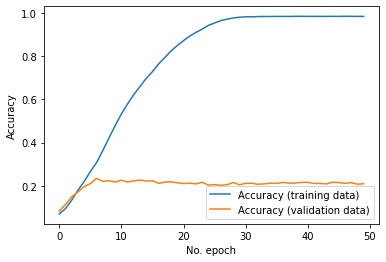

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Accuracy (training data)')
plt.plot(val_accuracy, label='Accuracy (validation data)')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

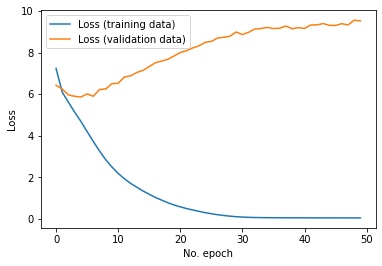

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Loss (training data)')
plt.plot(val_loss, label='Loss (validation data)')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

In [19]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.3):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=[None,None]):
    # Convert strings to token IDs.
    input_chars = tf.strings.split(inputs)
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    mStates, cStates = None, None
    predicted_logits, mStates, cStates = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, mStates,cStates

In [20]:
one_step_model = OneStep(model, vocab_from_ids, ids_from_vocab)
mStates,cStates = None,None
next_char = tf.constant(['یکی'])
result = [next_char]

for n in range(seq_length):
    next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
    result.append(next_char)

result = tf.strings.join(result, separator=' ')
print(result[0].numpy().decode('utf-8').replace("*", "\n").replace("/", "\t"), '\n\n' + '_'*80)

یکی رومئی بود میرین به نام 	 سرافراز و به ارای و با گنج و کام 
 فرستاد نزدیک قیصر پیام 	 که من سرفرازم به گنج و به نام 
 به من ده دل ‌ آرام دخترت را 	 به من تازه کن نام و افسرت را 
 چنین گفت قیصر که من زین سپس 	 نجویم بدین روی پیوند کس 
 کتایون و آن مرد ناسرفراز 	 

________________________________________________________________________________


In [21]:
def text_from_ids(ids):
  return tf.strings.reduce_join(vocab_from_ids(ids),separator=' ', axis=-1)

In [22]:
X_test_split = []
Y_test_split = []
for i in range(len(test)):
  text = text_from_ids(xtest[i])
  X_test_split.append(text.numpy().decode('utf-8'))
  text = text_from_ids(ytest[i])
  Y_test_split.append(text.numpy().decode('utf-8'))
print(X_test_split[0])

یکی نامور بود نامش سباک / ابا آلت و لشکر و رای پاک * که در شهر جهرم بد او پادشا / جهاندیده با داد و فرمانروا * مر او را خجسته پسر بود هفت / چو آگه شد از پیش بهمن برفت * ز جهرم بیامد سوی اردشیر / ابا لشکر و کوس و با دار و گیر * چو چشمش به روی سپهبد رسید / ز


In [23]:
one_step_model = OneStep(model, vocab_from_ids, ids_from_vocab)
results = []
for ind in range(len(xtest)):
    mStates,cStates = None,None
    next_char = tf.constant([X_test_split[ind].split()[0]])
    result = [next_char]

    for n in range(seq_length):
        next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
        result.append(next_char)

    result = tf.strings.join(result," ")
    result = result[0].numpy().decode('utf-8')
    results.append(result)

    if ind%50==0:
        print(X_test_split[ind].split()[0]+ ' ' + Y_test_split[ind].replace("*", "\n").replace("/", "\t"), '\n' + '_'*80)
        print(result.replace("*", "\n").replace("/", "\t"), '\n\n' + '_.'*50)
        

یکی نامور بود نامش سباک 	 ابا آلت و لشکر و رای پاک 
 که در شهر جهرم بد او پادشا 	 جهاندیده با داد و فرمانروا 
 مر او را خجسته پسر بود هفت 	 چو آگه شد از پیش بهمن برفت 
 ز جهرم بیامد سوی اردشیر 	 ابا لشکر و کوس و با دار و گیر 
 چو چشمش به روی سپهبد رسید 	 ز باره 
________________________________________________________________________________
یکی نامه بنوشت دیگر بطوس 	 پر از خون دل و روی چون سندروس 
 نخست آفرین کرد بر دادگر 	 کزو دید نیرو و بخت و هنر 
 خداوند پیروزی و فرهی 	 خداوند دیهیم شاهنشهی 
 پی پشه تا پر و چنگ عقاب 	 به خشکی چو پیل و نهنگ اندر آب 
 ز پیمان و فرمان او نگذرد 	 دم خویش بی رای او نشمرد 
 

_._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._._.
کنون پرشگفتی یکی داستان 	 بپیوندم از گفتهٔ باستان 
 نگه کن که مر سام را روزگار 	 چه بازی نمود ای پسر گوش دار 
 نبود ایچ فرزند مرسام را 	 دلش بود جویندهٔ کام را 
 نگاری بد اندر شبستان اوی 	 ز گلبرگ رخ داشت و ز مشک موی 
 از آن ماهش امید فرزند بود 	 که خورشید چهر و برومند بود 
 ز سام 
_

In [24]:
bleu_scores = []
hypothesis_all = []
reference_all = []
for ind in range(len(results)):
    hypothesis = results[ind].split()[1:]
    hypothesis_all = list(itertools.chain.from_iterable([hypothesis_all, hypothesis]))
    reference = Y_test_split[ind].split()
    reference_all = list(itertools.chain.from_iterable([reference_all, reference]))
    bleu_scores.append(sentence_bleu([reference], hypothesis, weights = [1]))

print(np.mean(bleu_scores))

0.2749554367201426


In [25]:
conf_mat = ConfusionMatrix(reference_all, hypothesis_all)
mat = np.zeros((len(words),len(words)))
for w1 in range(len(words)):
    for w2 in range(len(words)):
        try:
            mat[w1,w2] = conf_mat[words[w1],words[w2]]
        except:
            pass
conf = pd.DataFrame(mat, index=words,columns=words)

In [25]:
print(np.sort(np.diag(conf))[-10:])
print([words[i] for i in np.argsort(np.diag(conf))[-10:]])

In [26]:
#conf.to_csv('/content/drive/MyDrive/ANN/HW05/words_conf_mat.csv')

In [27]:
#plt.figure(figsize=(15,15))
#heatmap(conf)